In [64]:
# GoogleNet
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [65]:
batch_size = 8
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="../dataset/", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root="../dataset/", train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [66]:
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)

        self.branch5x5_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)

        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)

        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        output = [branch1x1, branch5x5, branch3x3, branch_pool]

        return torch.cat(output, dim=1)


In [67]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5)

        self.inception1 = InceptionA(in_channels=10)
        self.inception2 = InceptionA(in_channels=20)

        self.maxpool = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(1408, 10)


    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.maxpool(self.conv1(x)))
        x = self.inception1(x)
        x = F.relu(self.maxpool(self.conv2(x)))
        x = self.inception2(x)
        x = x.view(in_size, -1)
        x = self.fc(x)

        return x

In [68]:
device = torch.device(("cuda" if torch.cuda.is_available() else "cpu"))

model = Net().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [69]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_dataloader, 0):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 300 == 299:
            print("[%d, %5d] loss: %.3f" %(epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0

def test():
    correct = .0
    total = .0

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct/total)*100

[1,   300] loss: 1.811
[1,   600] loss: 0.416
[1,   900] loss: 0.280
[1,  1200] loss: 0.226
[1,  1500] loss: 0.181
[1,  1800] loss: 0.163
[1,  2100] loss: 0.150
[1,  2400] loss: 0.161
[1,  2700] loss: 0.126
[1,  3000] loss: 0.112
[1,  3300] loss: 0.113
[1,  3600] loss: 0.110
[1,  3900] loss: 0.105
[1,  4200] loss: 0.113
[1,  4500] loss: 0.120
[1,  4800] loss: 0.102
[1,  5100] loss: 0.088
[1,  5400] loss: 0.094
[1,  5700] loss: 0.095
[1,  6000] loss: 0.072
[1,  6300] loss: 0.103
[1,  6600] loss: 0.085
[1,  6900] loss: 0.096
[1,  7200] loss: 0.084
[1,  7500] loss: 0.078
accuracy on test set: 97%
[2,   300] loss: 0.066
[2,   600] loss: 0.081
[2,   900] loss: 0.075
[2,  1200] loss: 0.082
[2,  1500] loss: 0.064
[2,  1800] loss: 0.072
[2,  2100] loss: 0.071
[2,  2400] loss: 0.066
[2,  2700] loss: 0.062
[2,  3000] loss: 0.079
[2,  3300] loss: 0.062
[2,  3600] loss: 0.078
[2,  3900] loss: 0.075
[2,  4200] loss: 0.054
[2,  4500] loss: 0.061
[2,  4800] loss: 0.071
[2,  5100] loss: 0.056
[2,  540

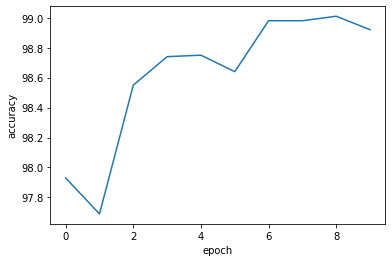

In [70]:
if __name__ == '__main__':
    epoch_list = []
    acc_list = []

    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
        print("accuracy on test set: %.4d%%" %acc)


    plt.plot(epoch_list, acc_list)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()

In [71]:
# ResNet
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.channels = in_channels
        self.conv1 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x + y)    # 注意: 先求和再激活

In [72]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5) # 88 = 24x3 + 16

        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)

        self.mp = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(512, 10) # 暂时不知道1408咋能自动出来的


    def forward(self, x):
        in_size = x.size(0)

        x = self.mp(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.conv2(x)))
        x = self.rblock2(x)

        x = x.view(in_size, -1)
        x = self.fc(x)
        return x

In [73]:
model = ResNet().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [80]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_dataloader, 0):
        inputs, target = data

        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100*correct/total)

In [81]:
if __name__ == '__main__':
    epoch_list = []
    acc_list = []

    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
        print("accuracy on test set: %.d%%" %acc)


    plt.plot(epoch_list, acc_list)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.show()

[1,   300] loss: 0.030
[1,   600] loss: 0.021
[1,   900] loss: 0.037
[1,  1200] loss: 0.049
[1,  1500] loss: 0.038
[1,  1800] loss: 0.033
[1,  2100] loss: 0.037
[1,  2400] loss: 0.042
[1,  2700] loss: 0.041
[1,  3000] loss: 0.041
[1,  3300] loss: 0.030
[1,  3600] loss: 0.031
[1,  3900] loss: 0.024
[1,  4200] loss: 0.034
[1,  4500] loss: 0.035
[1,  4800] loss: 0.037
[1,  5100] loss: 0.033
[1,  5400] loss: 0.031
[1,  5700] loss: 0.030
[1,  6000] loss: 0.042
[1,  6300] loss: 0.027
[1,  6600] loss: 0.050
[1,  6900] loss: 0.030
[1,  7200] loss: 0.033
[1,  7500] loss: 0.033
accuracy on test set: 0098%
[2,   300] loss: 0.027
[2,   600] loss: 0.031
[2,   900] loss: 0.027
[2,  1200] loss: 0.034
[2,  1500] loss: 0.022
[2,  1800] loss: 0.023
[2,  2100] loss: 0.022
[2,  2400] loss: 0.028
[2,  2700] loss: 0.026
[2,  3000] loss: 0.024
[2,  3300] loss: 0.024
[2,  3600] loss: 0.021
[2,  3900] loss: 0.026
[2,  4200] loss: 0.024
[2,  4500] loss: 0.035
[2,  4800] loss: 0.017
[2,  5100] loss: 0.037
[2,  5

KeyboardInterrupt: 